In [2]:
import pyxdf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from warnings import warn
import math
from HIL.cost_processing.ECG import ECGComplexity
import neurokit2 as nk

import os
import glob


In [3]:
import antropy as ant
# !pip install antropy
# !pip list

## Export ECG data and acceleration data from xdf file

In [4]:
# os.chdir(r'C:\Users\sruth\OneDrive - University of Illinois at Chicago\Documents\MATLAB\6. HIL\ECG_processing\ETC optimization\Polar accelerometry validation\normal frequency\sub-P001\ses-S001\eeg')

# filename = "sub-P001_ses-S001_task-Default_run-001_eeg.xdf" # File name

os.chdir(r'C:\Users\sruth\OneDrive - University of Illinois at Chicago\Documents\MATLAB\6. HIL\ECG_processing\Energy adaptation optimization\arl testing Sep 27 2024\User preferred\sub-P001\ses-S001\eeg')

filename = "sub-P001_ses-S001_task-Default_run-001_eeg.xdf" # File name

data, header = pyxdf.load_xdf(filename)

In [7]:
# # Checking the format of "data" in the xdf file
# data[1] #- ['polar accel'] # acceleration data, with sampling rate = 200 Hz
# data[0] #- ['polar ECG'] # ECG raw data, with sampling rate = 130 Hz

{'info': defaultdict(list,
             {'name': ['polar ECG 2'],
              'type': ['ECG'],
              'channel_count': ['1'],
              'channel_format': ['float32'],
              'source_id': ['myuid2424'],
              'nominal_srate': ['130.0000000000000'],
              'version': ['1.100000000000000'],
              'created_at': ['765233.4739662000'],
              'uid': ['666381a9-c6dd-4d92-87cc-c5276b69bc92'],
              'session_id': ['default'],
              'hostname': ['MIE-Kimmlaptop1'],
              'v4address': [None],
              'v4data_port': ['16573'],
              'v4service_port': ['16573'],
              'v6address': [None],
              'v6data_port': ['16573'],
              'v6service_port': ['16573'],
              'desc': [defaultdict(list,
                           {'manufacturer': ['Polar'],
                            'channels': [defaultdict(list,
                                         {'channel': [defaultdict(list,
           

In [8]:
for data_streams in data:
    
    print(data_streams['info']['name'])
    
    if data_streams['info']['name']==['polar ECG 2']:
        ecg_data=data_streams['time_series'] # this is the ecg data
        ecg_time_stamps=data_streams['time_stamps']
        
    if data_streams['info']['name']==['polar accel']:
        accel_data=data_streams['time_series'] # this is the acceleration data
        accel_time_stamps=data_streams['time_stamps']

    if data_streams['info']['name']==['TestInf']:
        condition_data = data_streams['time_series'] # this is the condition data (e.g. "first parameter", "second parameter", etc)
        condition_time_stamps = data_streams['time_stamps']
    
    if data_streams['info']['name']==['Change_parm']:
        parm_data = data_streams['time_series'] 
        parm_time_stamps = data_streams['time_stamps']

['polar ECG 2']
['polar accel']
['Polar_symmetry']
['Met_cost']


In [21]:
accel_data

array([[-699.,  162.,   55.],
       [-695.,  163.,   61.],
       [-700.,  171.,   62.],
       ...,
       [-785., -102., -144.],
       [-792.,  -91., -146.],
       [-787.,  -86., -141.]], dtype=float32)

In [22]:
# Check duration
sampling_rate = 200 # Hz # sampling rate for acceleration data is 200 Hz
duration = len(accel_data)/sampling_rate
duration # in seconds

242.46

In [25]:
accel_signal = accel_data.T
accel_signal

array([[-699., -695., -700., ..., -785., -792., -787.],
       [ 162.,  163.,  171., ..., -102.,  -91.,  -86.],
       [  55.,   61.,   62., ..., -144., -146., -141.]], dtype=float32)

In [32]:
# plt.plot(accel_signal[0][0:1000])     # x[0] seems to be vertical acceleration.
# # plt.xlim([0, 1000])

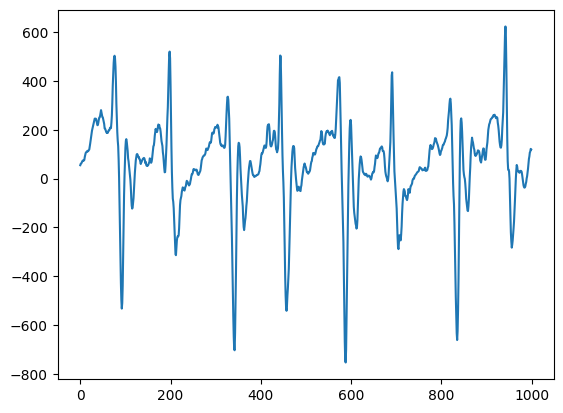

In [26]:
plt.plot(accel_signal[2][0:1000])     # x[2] seems to be forward-backward acceleration
# plt.xlim([0, 1000])

## Extract stride intervals from acceleration data

In [30]:
# # Acceleration in the vertical direction
# peaks_plt, _ = signal.find_peaks(-accel_signal[0][0:10000], height=1250, distance=80)  # Vertical acceleration - Adjust the height parameter as needed
# plt.figure(figsize=(10, 6))
# plt.plot(-accel_signal[0][0:10000], label='Accel Signal')
# plt.plot(peaks_plt, -accel_signal[0][peaks_plt], "x", label='Detected Peaks')
# plt.legend()
# plt.title('Accel Signal and Detected Peaks')
# plt.xlabel('Sample')
# plt.ylabel('Amplitude')
# plt.show()

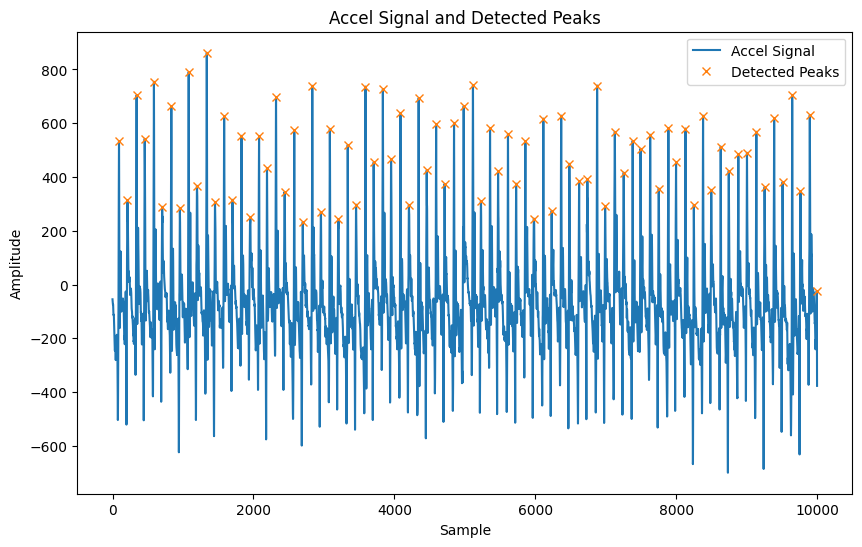

In [33]:
# Acceleration in the forward-aft direction
peaks_plt, _ = signal.find_peaks(-accel_signal[2][0:10000], height=-50, distance=75)  # Forward-aft acceleration - Adjust the height parameter as needed
plt.figure(figsize=(10, 6))
plt.plot(-accel_signal[2][0:10000], label='Accel Signal')
plt.plot(peaks_plt, -accel_signal[2][peaks_plt], "x", label='Detected Peaks')
plt.legend()
plt.title('Accel Signal and Detected Peaks')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

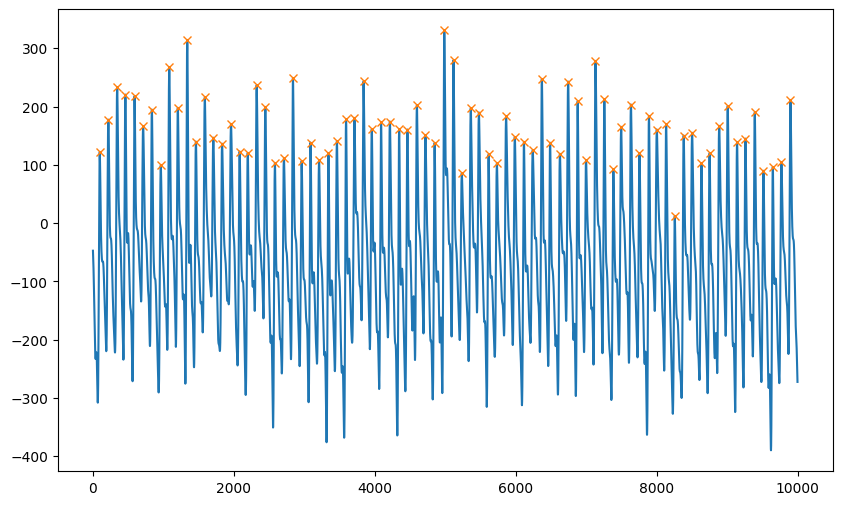

In [34]:
# Visualization of the filtered signal (filter a portion of the signal for demonstration and plotting)

from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

# Filtering step to smooth the signal and reduce noise
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Sampling frequency (Hz)
fs = 200  

# Low-pass filter parameters (cutoff frequency in Hz)
cutoff = 5.0  # This will help smooth out high-frequency noise

# Apply low-pass filter to the forward-aft acceleration signal
filtered_signal_plt = butter_lowpass_filter(-accel_signal[2][0:10000], cutoff, fs)

# Peak detection
# Adjust the 'distance' parameter to account for step frequency at 200 Hz
# E.g., if walking cadence is about 80 steps/min (1.33 steps/sec), then distance is roughly 150 samples between heel strikes
peaks_plt, _ = signal.find_peaks(filtered_signal_plt, height=-50, distance=75)  # Adjust height as necessary

# Plotting the signal and detected peaks
plt.figure(figsize=(10, 6))
plt.plot(filtered_signal_plt, label='Filtered Accel Signal')
plt.plot(peaks_plt, filtered_signal_plt[peaks_plt], "x", label='Detected Peaks')

In [60]:
# Filter the entire signal

# Apply low-pass filter to the forward-aft acceleration signal
filtered_signal = butter_lowpass_filter(-accel_signal[2], cutoff, fs)

# Peak detection
# Adjust the 'distance' parameter to account for step frequency at 200 Hz
# E.g., if walking cadence is about 80 steps/min (1.33 steps/sec), then distance is roughly 150 samples between heel strikes
peaks, _ = signal.find_peaks(filtered_signal, height=-100, distance=75)  # Adjust height as necessary

# Calculate intervals between peaks (in samples)
intervals = np.diff(peaks)

In [61]:
len(peaks)

383

In [62]:
stride_times_left = []
stride_times_right =  []
step_time_left = []
step_time_right = []

for i in range(0, len(intervals) - 2, 2):
    # Calculate stride times and divide by sampling_rate to get the value in seconds 
    stride_times_left.append((intervals[i] + intervals[i+1]) / sampling_rate)
    stride_times_right.append((intervals[i+1] + intervals[i+2]) / sampling_rate)
    
    # Calculate step times and divide by sampling_rate to get the value in seconds
    step_time_left.append(intervals[i] / sampling_rate)
    step_time_right.append(intervals[i+1] / sampling_rate)

stride_times_left = np.array(stride_times_left)
stride_times_right = np.array(stride_times_right)
step_time_left = np.array(step_time_left)
step_time_right = np.array(step_time_right)

In [63]:
step_time_left

array([0.61 , 0.58 , 0.61 , 0.635, 0.605, 0.615, 0.605, 0.63 , 0.575,
       0.61 , 0.64 , 0.62 , 0.605, 0.6  , 0.595, 0.585, 0.625, 0.585,
       0.61 , 0.685, 0.59 , 0.575, 0.59 , 0.615, 0.62 , 0.585, 0.585,
       0.595, 0.63 , 0.55 , 0.605, 0.555, 0.61 , 0.595, 0.575, 0.605,
       0.595, 0.62 , 0.61 , 0.61 , 0.615, 0.565, 0.57 , 0.59 , 0.595,
       0.6  , 0.62 , 0.595, 0.615, 0.575, 0.625, 0.605, 0.64 , 0.595,
       0.615, 0.635, 0.615, 0.61 , 0.64 , 0.635, 0.6  , 0.635, 0.62 ,
       0.57 , 0.63 , 0.675, 0.59 , 0.605, 0.615, 0.63 , 0.64 , 0.625,
       0.62 , 0.615, 0.6  , 0.6  , 0.635, 0.55 , 0.62 , 0.615, 0.595,
       0.595, 0.62 , 0.585, 0.59 , 0.56 , 0.62 , 0.605, 0.615, 0.605,
       0.635, 0.585, 0.615, 0.59 , 0.65 , 0.62 , 0.615, 0.615, 0.63 ,
       0.605, 0.635, 0.61 , 0.615, 0.64 , 0.6  , 0.59 , 0.625, 0.615,
       0.64 , 0.635, 0.605, 0.645, 0.625, 0.635, 0.63 , 0.61 , 0.64 ,
       0.645, 0.62 , 0.615, 0.625, 0.61 , 0.62 , 0.62 , 0.585, 0.62 ,
       0.66 , 0.58 ,

In [64]:
step_time_right

array([0.63 , 0.65 , 0.62 , 0.6  , 0.67 , 0.63 , 0.625, 0.615, 0.635,
       0.68 , 0.64 , 0.63 , 0.665, 0.65 , 0.645, 0.66 , 0.66 , 0.67 ,
       0.65 , 0.655, 0.635, 0.69 , 0.655, 0.65 , 0.65 , 0.695, 0.675,
       0.67 , 0.64 , 0.695, 0.675, 0.665, 0.635, 0.665, 0.685, 0.66 ,
       0.66 , 0.665, 0.64 , 0.675, 0.64 , 0.675, 0.665, 0.655, 0.65 ,
       0.63 , 0.665, 0.64 , 0.655, 0.685, 0.675, 0.605, 0.645, 0.67 ,
       0.63 , 0.64 , 0.635, 0.655, 0.65 , 0.63 , 0.635, 0.7  , 0.645,
       0.69 , 0.675, 0.655, 0.665, 0.635, 0.64 , 0.655, 0.655, 0.645,
       0.67 , 0.65 , 0.655, 0.63 , 0.645, 0.67 , 0.635, 0.655, 0.695,
       0.64 , 0.63 , 0.675, 0.66 , 0.675, 0.67 , 0.635, 0.665, 0.635,
       0.635, 0.67 , 0.67 , 0.66 , 0.64 , 0.615, 0.67 , 0.655, 0.675,
       0.625, 0.67 , 0.665, 0.66 , 0.65 , 0.66 , 0.655, 0.63 , 0.635,
       0.645, 0.69 , 0.66 , 0.63 , 0.645, 0.655, 0.67 , 0.665, 0.625,
       0.67 , 0.67 , 0.645, 0.65 , 0.625, 0.665, 0.645, 0.665, 0.655,
       0.64 , 0.655,

In [66]:
symmetry_index = abs((2 * (step_time_left - step_time_right) / (step_time_left + step_time_right)) * 100)
symmetry_index

7.069797056694614

In [44]:
# Calculate all stride metrics
# Step time array
# Interleave the left and right step times
combined_step_times = np.empty(step_time_left.size + step_time_right.size, dtype=step_time_left.dtype)
combined_step_times[0::2] = step_time_left
combined_step_times[1::2] = step_time_right

# Stride time array
# Interleave the left and right stride times
combined_stride_times = np.empty(stride_times_left.size + stride_times_right.size, dtype=stride_times_left.dtype)
combined_stride_times[0::2] = stride_times_left
combined_stride_times[1::2] = stride_times_right

# Symmetry 
symmetry = symmetry_index.mean()
avg_symmetry_index = np.abs((2 * (step_time_left.mean() - step_time_right.mean()) / (step_time_left.mean() + step_time_right.mean())) * 100)

# Step time variability
step_time_var = np.std(combined_step_times)
step_time_complexity = ECGComplexity.ETC(combined_step_times, "percentile")  # using effort-to-compress

# Stride time variability
stride_time_var = np.std(combined_stride_times)
stride_time_complexity = ECGComplexity.ETC(combined_stride_times, "percentile")  # using effort-to-compress

# Step time regularity (Detrended Fluctuation Analysis)
dfa_index_step_times = ant.detrended_fluctuation(combined_step_times)
step_time_dfa = dfa_index_step_times

# Stride time regularity (Detrended Fluctuation Analysis)
dfa_index_stride_times = ant.detrended_fluctuation(combined_stride_times)
stride_time_dfa = dfa_index_stride_times

# Step time mean
mean_step_time = np.mean(combined_step_times)

# Stride time mean
mean_stride_time = np.mean(combined_stride_times)

# Save data to an Excel file in a specified folder

# Create a DataFrame
data = {
    'Symmetry': [symmetry],
    'Average Symmetry Index': [avg_symmetry_index],
    'Step Time Variability': [step_time_var],
    'Step Time Complexity': [step_time_complexity],
    'Stride Time Variability': [stride_time_var],
    'Stride Time Complexity': [stride_time_complexity],
    'Step Time DFA': [step_time_dfa],
    'Stride Time DFA': [stride_time_dfa],
    'Mean Step Time': [mean_step_time],
    'Mean Stride Time': [mean_stride_time]
}

df = pd.DataFrame(data)

# Save the DataFrame to an Excel file
df.to_excel('P0_gait_analysis.xlsx', index=False)